# 4장 모델 훈련

## 주요 내용

- 경사 하강법
- 모델 규제
- 로지스틱 회귀/소프트맥스 회귀

__참고:__
핵심 설명과 코드는 &#x1f511;로 표시되었으며 굳이 알아둘 필요가 없는 코드는 &#x270b;로 표시되었다.

## 기본 설정

- 필수 모듈 불러오기
- 그래프 출력 관련 기본 설정 지정

In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 어레이 데이터를 csv 파일로 저장하기
def save_data(fileName, arrayName, header=''):
    np.savetxt(fileName, arrayName, delimiter=',', header=header, comments='')

## 4.1 선형 회귀 (p. 158)

아래 코드는 선형 회귀 학습 과정을 설명하기 위해 사용되는 하나의 특성을 사용하는
간단한 훈련 데이터를 생성한다.

* `X`: 훈련 세트. 하나의 특성 `x1`을 갖는 100개의 데이터
* `y`: 100 개의 레이블. 기본적으로 `4 + 3 * x`의 형식을 따르나 훈련을 위해 잡음(noise)를 추가 했음.

__참고:__ 정규분포를 따르는 부동소수점 100개를 무작위로 생성하여 잡음으로 사용하였다.

In [2]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

In [3]:
linreg_data = np.c_[X, y]

In [4]:
linreg_data[:5]

array([[0.74908024, 6.33428778],
       [1.90142861, 9.40527849],
       [1.46398788, 8.48372443],
       [1.19731697, 5.60438199],
       [0.31203728, 4.71643995]])

특성 `x1`과 레이블 `y`의 관계를 그리면 다음과 같다.
기본적으로 `y = 4 + 3 * x` 의 선형관계를 갖지만 잡음으로 인해 데이터가 퍼져 있다.

그림 저장: generated_data_plot


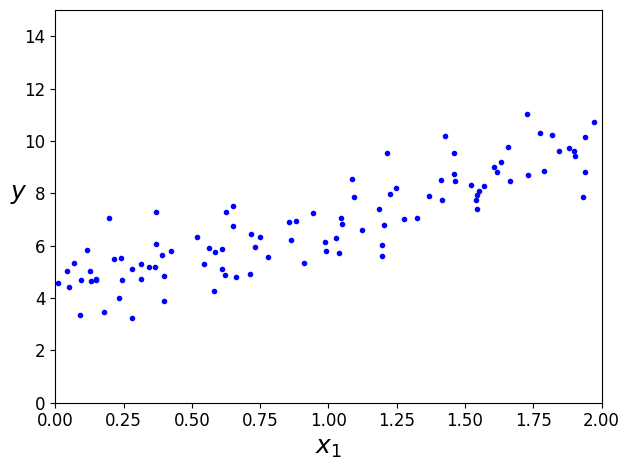

In [5]:
plt.plot(X, y, "b.")                          # 파랑 점: 훈련 세트 산점도
plt.xlabel("$x_1$", fontsize=18)              # x축 표시
plt.ylabel("$y$", rotation=0, fontsize=18)    # y축 표시
plt.axis([0, 2, 0, 15])                       # x축, y축 구간 지정

save_fig("generated_data_plot")
plt.show()

### 4.1.1 정규 방정식 (p. 160)

일반적으로 $n$개의 특성을 갖는 임의의 크기의 데이터셋 `X`가 주어졌을 때,
$(\mathbf{X}^T \mathbf{X})^{-1}$의 역행렬이 존재하고 실제로 일정 시간 내에 계산이 가능하다면 최적의
파라미터 조합 $\boldsymbol{\hat\theta}$ 를 아래 정규 방정식으로 직접 구할 수 있다.

$$
\hat{\boldsymbol{\theta}} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}
$$

아래 코드는 위 정규 방정식을 위에서 생성한 훈련 세트에 대해 계산한다.

* `np.ones((100, 1))`: 절편 $\theta_0$를 고려하기 위해 훈련세트의 0번 열에 추가되는 `x0=1`로 이루어진 벡터
* `X_b`: 모든 샘플에 대해 `x0=1`이 추가된 어레이

__주의사항:__ 1 벡터를 추가하는 일은 여기서만 설명을 위해 사용된다.
사이킷런의 모델을 사용할 때는 모델이 알아서 처리해준다.

In [6]:
X_b = np.c_[np.ones((100, 1)), X]  # 모든 샘플에 x0 = 1 추가
X_b[:5]

array([[1.        , 0.74908024],
       [1.        , 1.90142861],
       [1.        , 1.46398788],
       [1.        , 1.19731697],
       [1.        , 0.31203728]])

In [7]:
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

계산된 $\boldsymbol{\hat\theta} = [\theta_0, \theta_1]$ 은 다음과 같다.

In [8]:
theta_best

array([[4.21509616],
       [2.77011339]])

계산된 $\boldsymbol{\hat\theta}$ 를 이용하여 `x1=0`과 `x1=2`일 때의 예측값 $\hat y$는 단순한 행렬 곱셈에 불과하다.

$$\hat{y} = \mathbf{X}\, \boldsymbol{\hat{\theta}}$$

예측을 위해서도 먼저 `x0=1` 열을 추가해야 한다.

__주의사항:__ $\mathbf{X}$ 와 $\hat\theta$ 의 순서에 너무 민감해할 필요는 없다.
설명하는 방식에 따라 순서가 바뀌거나 전치행렬이 사용될 뿐이며, 결과는 모두 동일하다.

In [9]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # 모든 샘플에 x0 = 1 추가
X_new_b

array([[1., 0.],
       [1., 2.]])

행렬 곱셈에 의한 예측값은 다음과 같다.

In [10]:
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

$\theta_0$ 을 절편으로, $\theta_1$ 을 기울기로 하는 직선은 아래와 같다.

그림 저장: linear_model_predictions_plot


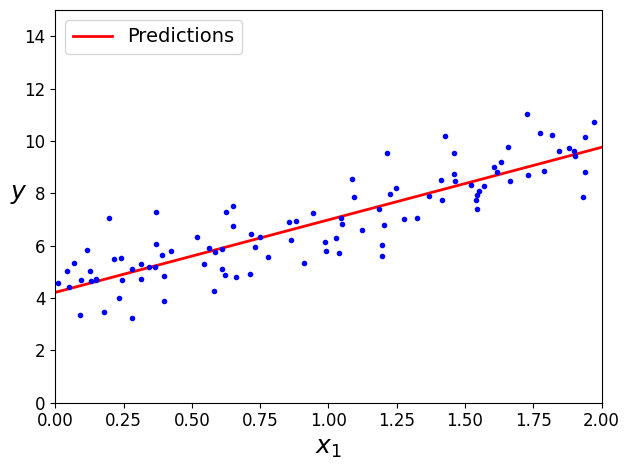

In [11]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions") # 빨강 직선. label은 범례 지정용

plt.plot(X, y, "b.")                                               # 파란 점: 훈련 세트 산점도
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)

plt.legend(loc="upper left", fontsize=14)                          # 범례 위치
plt.axis([0, 2, 0, 15])                                            # x축, y축 구간 지정

save_fig("linear_model_predictions_plot")
plt.show()

### 사이킷런의 `LinearRegression` 모델

`LinearRegression` 모델은 특잇값 분해(SVD) 방식을 이용하여 계산된 무어-펜로즈의 유사 역행렬 $\mathbf{X}^+$를
이용하여 파라미터 $\hat\theta$를 계산한다.

$$
\hat{\boldsymbol{\theta}} = \mathbf{X}^+ \mathbf{y}
$$

훈련된 모델의 `intercept_`와 `coef_` 속성에 절편 $\theta_0$ 과 기울기 $\theta_1$ 이 저장된다.

In [12]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

`x1=0`과 `x1=2`에 대한 예측값과 앞서 수동으로 계산된 값과 동일하다.

In [13]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

&#x270b; __참고:__ `LinearRegression` 클래스는 `scipy.linalg.lstsq()` 함수를
사용하므로 이 함수를 직접 사용할 수도 있다.

In [14]:
import scipy
theta_best_svd, residuals, rank, s = scipy.linalg.lstsq(X_b, y)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

&#x270b; `numpy.linalg.lstsq()` 함수도 동일하게 작동한다.

In [15]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

&#x270b; 무어-펜로즈의 유사 역행렬 $\mathbf{X}^{+}$ 는 `np.linalg.pinv()`을 사용해서 구해지며,
이를 아래 수식처럼 이용하면 동일한 최적 파라미터를 구한다.

$$\boldsymbol{\hat{\theta}} = \mathbf{X}^{+}\hat{y}$$

In [16]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

## 4.2 경사 하강법 (p. 164)

앞선 언급한 무어-펜로즈 유사 역행렬을 구하는 알고리즘의 계산 복잡도는 $O(n^2)$이다.
즉 특성 수가 늘어날 수록 계산 시간은 제곱 지수승으로 늘어난다.
따라서 많은 수의 특성을 사용하는 데이터에 대해서는 SVD 방식을 사용하는
사이킷런의 `LinearRegrssion` 모델을 사용할 수 없으며
배치 경사 하강법에 기반한 모델을 대신 사용해야 한다.

### 4.2.1 배치 경사 하강법 (p.168)

임의로 지정된 파라미터 $\boldsymbol{\hat\theta}$로 시작한 후에
비용 함수(MSE)가 작아지는 방향으로 조금씩 파라미터를 조정한다.

$$
\begin{align*}
\mathrm{MSE}(\theta) & = \mathrm{MSE}(\mathbf X, h_\theta) \\
 & = \frac 1 m \sum_{i=1}^{m} \big(\hat y^{(i)} - y^{(i)}\big)^2 \\[2ex]
\hat y^{(i)} & = \theta^{T}\, \mathbf{x}^{(i)} \\
 & = \theta_0 + \theta_1\, \mathbf{x}_1^{(i)} + \cdots + \theta_n\, \mathbf{x}_n^{(i)}
\end{align*}
$$

파라미터를 조정할 때 사용하는 기준은 비용 함수의 그레이디언트 벡터의 방향과 크기이다.

$$
\nabla_\theta \text{MSE}(\boldsymbol{\theta})
 = \frac{2}{m}\, \mathbf{X}^T (\mathbf{X} \boldsymbol{\theta} - \mathbf{y})
$$

파라미터 조정은 아래 방식으로 이루어진다. 단, $\eta$는 학습률을 가리킨다.

$$
\boldsymbol{\theta}^{(\text{next step})} = \boldsymbol{\theta}^{(\text{previous step})} - \eta\cdot \nabla_\theta \text{MSE}(\boldsymbol{\theta})
$$

아래 코드는 $\theta_0$과 $\theta_1$을 무작위로 지정한 다음에
앞서 언급한 학습률 조정 과정을 수동으로 1,000번 진행한 결과를 보여준다.

In [17]:
eta = 0.1                     # 학습률
n_iterations = 1000           # 1000번 파라미터 조정
m = 100                       # 샘플 수

theta = np.random.randn(2,1)  # 파라미터 무작위 초기화

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)   # 비용 함수 그레이디언트
    theta = theta - eta * gradients                   # 파라미터 업데이트

앞서 얻은 결과와 동일한 최적의 파라미터가 계산된다.

In [18]:
theta

array([[4.21509616],
       [2.77011339]])

#### 학습률과 모델 학습

&#x270b; 아래 코드는 학습률에 따라 파라미터 학습과정이 어떻게 달라질 수 있는지를 보여주기 위해
세 개의 그래프를 그려준다.

- `theta_path_bgd` 변수: 배치 경사 하강법에서 조정되는 파라미터를 순처적으로 저장하는 용도의 리스트.
    아래에서 세 종류의 경사 하강법을 비교하는 그림에서 활용됨.
- `plot_gradient_descent()` 함수: 선형 회귀 모델 훈련 과정의 처음 10단계를 보여주는 도표 그려주는 함수.

In [19]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")    # 훈련 세트 산점도

    n_iterations = 1000     # 1000번 반복 훈련
    for iteration in range(n_iterations):

        # 초반 10번 선형 모델(직선) 그리기
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)

        # 파라미터 조정
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients

        # 조정되는 파라미터를 모두 리스트에 저장 (theta_path=None 옵션이 아닌 경우)
        if theta_path is not None:
            theta_path.append(theta)

    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

파랑 직선은 초반 10번의 모델 학습과정을 보여준다.
학습률(`eta`)에 따라 학습 과정이 많이 다를 수 있음을 잘 보여준다.

그림 저장: gradient_descent_plot


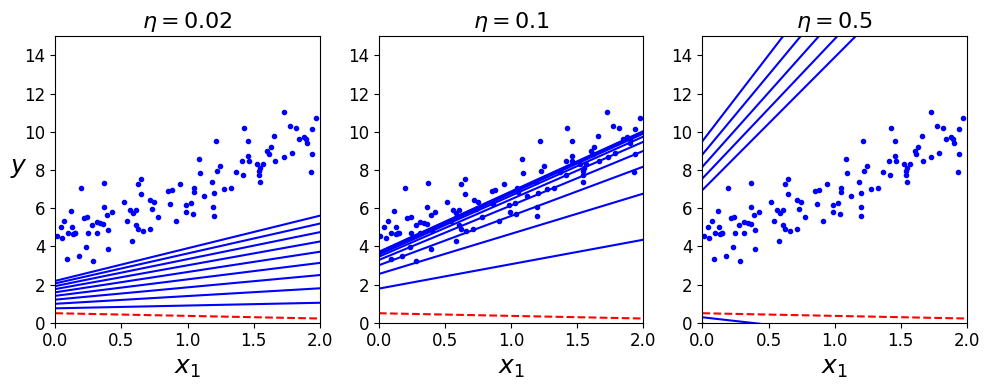

In [20]:
np.random.seed(42)
theta = np.random.randn(2,1)  # 무작위 초기화

plt.figure(figsize=(10,4))    # 도표 크기 지정

# eta=0.02
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)

# eta=0.1
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)

# eta=0.5
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

save_fig("gradient_descent_plot")
plt.show()

__참고:__ 사이킷런은 배치 경사 하강법을 지원하는 모델을 제공하지 않는다.

### 4.2.2 확률적 경사 하강법 (p.172)

아래 코드는 확률적 경사 하강법의 작동 과정을 보여주는 코드이다.

* `theta_path_sgd` 변수: 확률적 경사 하강법에서 조정되는 파라미터를 순처적으로 저장하는 용도의 리스트.
    아래에서 세 종류의 경사 하강법을 비교하는 그림에서 활용됨.

In [21]:
theta_path_sgd = []

m = len(X_b)
np.random.seed(42)

* `n_epochs=50`: 총 50번의 에포크 기간동안 훈련 진행
* `t0` 과 `t1`: 학습 스케줄을 위한 하이퍼파라미터 역할 수행

In [22]:
n_epochs = 50   # 에포크 수
t0, t1 = 5, 50  # 학습 스케줄 하이퍼파라미터

def learning_schedule(t):
    return t0 / (t + t1)

모델이 수렴값 근처에서 진동하는 것을 확인할 수 있다.

그림 저장: sgd_plot


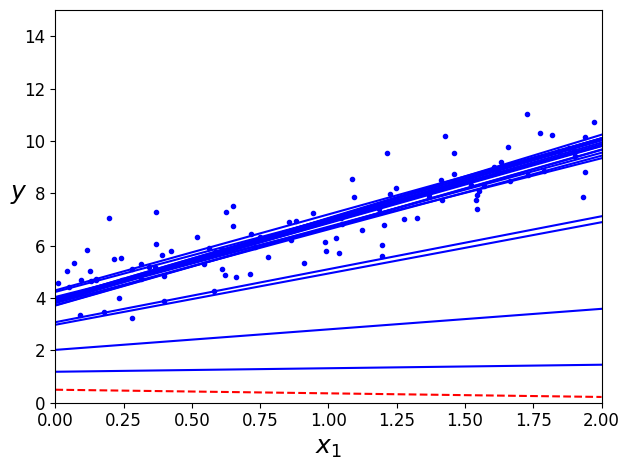

In [23]:
theta = np.random.randn(2,1)    # 파라미터 랜덤 초기화

for epoch in range(n_epochs):

    # 매 샘플에 대해 그레이디언트 계산 후 파라미터 업데이트
    for i in range(m):

        # 처음 20번 선형 모델(직선) 그리기
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)
            style = "b-" if i > 0 else "r--"
            plt.plot(X_new, y_predict, style)

        # 파라미터 업데이트
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]

        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)  # 하나의 샘플에 대한 그레이디언트 계산
        eta = learning_schedule(epoch * m + i)        # 학습 스케쥴을 이용한 학습률 조정
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
save_fig("sgd_plot")
plt.show()

그렇지만 50번만의 에포크 만으로 상당히 좋은 파라미터를 찾는다.

In [24]:
theta

array([[4.21076011],
       [2.74856079]])

#### 사이킷런의 `SGDRegressor` 모델

`SGDRegressor` 모델은 확률적 경사 하강법을 사용하며 따라서 매우 빠르게 학습한다.

In [25]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None, random_state=42)

In [26]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.24365286]), array([2.8250878]))

### 4.2.3 미니배치 경사 하강법 (p.175)

아래 코드는 크기 20인 배치를 활용하는 미니배치 경사 하강법을 구현한다.

* `theta_path_mgd` 변수: 미니배치 경사 하강법에서 조정되는 파라미터를 순처적으로 저장하는 용도의 리스트.
    아래에서 세 종류의 경사 하강법을 비교하는 그림에서 활용됨.
    
* `n_iterations = 50`: 에포크 수 50
* `minibatch_size = 20`: 배치 크기 20

In [27]:
theta_path_mgd = []

n_iterations = 50
minibatch_size = 20

np.random.seed(42)
theta = np.random.randn(2,1)  # 랜덤 초기화

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

학습 스케줄이 사용된 미니배치 수 `t`에 의존한다.

* `t`: 훈련에 사용된 미니배치 개수. 학습 스케줄에 사용됨.

In [28]:
t = 0

for epoch in range(n_iterations):

    # 에포크가 바뀔 때마다 훈련 데이터 섞기
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]

    # 20개 데이터 샘플을 훈련할 때마다 파라미터 업데이트
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)        # 학습 스케줄 활용
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

In [29]:
theta

array([[4.25214635],
       [2.7896408 ]])

### 배치/확률적/미니배치 경사 하강법 파라미터 학습과정 비교

아래 코드는 아래 세 개의 변수에 저정된 파라미터 값들을 도표로 보여준다.

* 파랑선: 배치 경사 하강법의 경우이며 최적의 파라미터에 제대로 수렴한다.
* 빨강선: 확률적 경사 하강법의 경우이며 최적의 파라미터에 근처에서 심하게 요동친다.
* 초록선: 미니배치 경사 하강법의 경우이며 최적의 파라미터에 근처에서 상대적으로 덜 요동친다.

In [30]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

그림 저장: gradient_descent_paths_plot


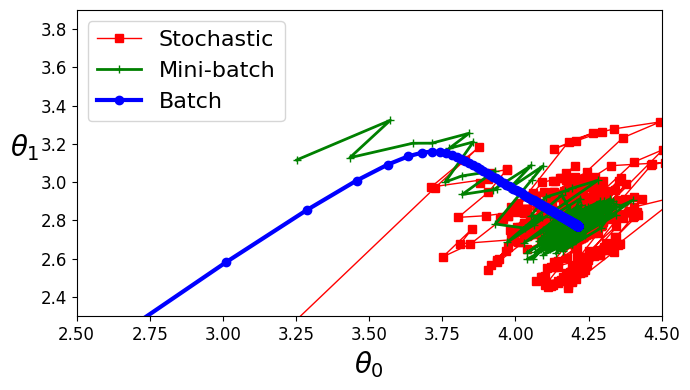

In [31]:
plt.figure(figsize=(7,4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1, label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2, label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3, label="Batch")
plt.legend(loc="upper left", fontsize=16)
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$   ", fontsize=20, rotation=0)
plt.axis([2.5, 4.5, 2.3, 3.9])
save_fig("gradient_descent_paths_plot")
plt.show()

## 4.3 다항 회귀 (p.177)

아래 코드는 무작위로 100개의 훈련 데이터를 생성한다.
한 개의 특성만 사용하며 타깃은 아래 2차 다항식으로 생성한 다음에 잡음을 추가한다.

$$y = 0.5\cdot x_1^2 + 2$$

__주의사항:__ 여기서 2차 함수를 이용하여 타깃을 계산하였지만 이는 단순히 예제를 위해서이다.
일반적으로는 특성과 타깃 사이에 어떤 연관성이 있는지 미리 알 수 없다는 것을 염두해야 한다.

In [32]:
np.random.seed(42)

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

훈련 세트의 산점도는 다음과 같다.

그림 저장: quadratic_data_plot


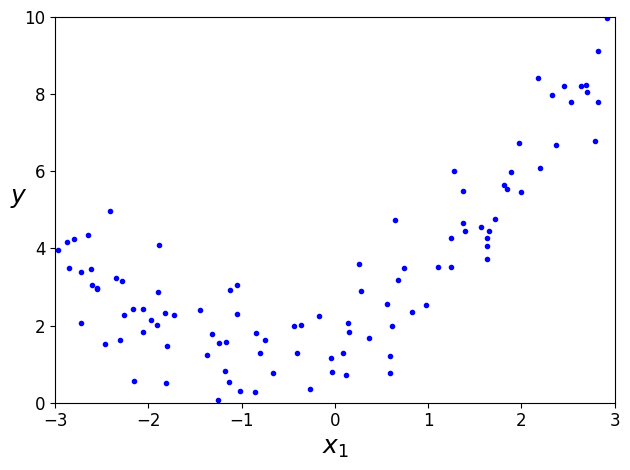

In [33]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_data_plot")
plt.show()

선형 회귀 모델을 바로 적용하면 좋은 모델을 얻을 수 없다.
따라서 다항 회귀 기법을 사용하여 보다 좋은 모델을 훈련시킬 수 있는지 확인하려 한다.

아래 코드는 2차 다항 회귀 변환기 이용하여 하나의 특성 `x1`을 갖는 데이터를
`x1`과 `x1**2`두 개의 특성을 갖는 데이터로 변환하는 것을 보여준다.

* `PolynomialFeatures`: 다항 회귀 변환기
* `degree=2`: 2차 다항식을 활용하라고 지정하기. 3, 4, 등 임의의 양의 정수를 사용할 수 있음.
* `include_bias=False`: 절편(편향)을 변환된 어레이에 추가할지 여부 지정. 기본값은 `True` 이지만
    여기서는 사용하지 않음. 이유는 변환된 어레이를 `LinearRegression()` 모델에서
    사용할 예정이며, 거기서 입력 어레이는 편향을 사용하지 않기 때문임.

In [34]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

첫째 훈련 데이터는 원래 특성 $x_1$만 갖는다.

In [35]:
X[0]

array([-0.75275929])

반면에 변환된 첫째 훈련 데이터는 두 개의 특성 $x_1, x_1^2$ 를 갖는다.

In [36]:
X_poly[0]

array([-0.75275929,  0.56664654])

변환된 데이터를 이용하여 선형 회귀 모델을 학습시킨다.

In [37]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)

LinearRegression()

학습된 모델의 절편과 기울기는 다음과 같다.

__참고:__ 2차 다항 회귀 모델을 적용하기 위해 변환된 데이터는
절편에 대한 파라미터 $\theta_0$와 두 개의 특성 $x_1$과 $x_1^2$ 각각에 대한 파라미터
$\theta_1$과 $\theta_2$를 갖는다.

In [38]:
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

아래 코드는 새로운 샘플 100개에 대해 앞서 훈련시킨 다항 회귀 모델을 이용하여 예측을 수행한 후
예측 결과를 그래프로 그린다.

그림 저장: quadratic_predictions_plot


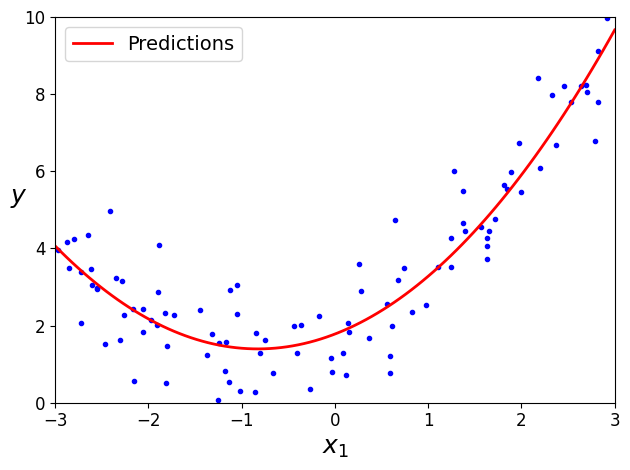

In [39]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)     # 새로운 샘플 100개
X_new_poly = poly_features.transform(X_new)       # 2차 다항 회귀 모델 데이터로 변환
y_new = lin_reg.predict(X_new_poly)               # 예측하기

plt.plot(X, y, "b.")                                            # 기존 데이터 산점도
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")  # 예값 그래프

plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([-3, 3, 0, 10])
save_fig("quadratic_predictions_plot")
plt.show()

## 4.4 학습 곡선 (p. 179)

아래 코드는 아래 세 모델을 사용하여 얻어진 예측값을 비교한다.

* 초록 실선 그래프: 300차 다항 회귀 모델
* 파랑 파선 그래프: 2차 다항 회귀 모델
* 빨강 철망 그래프: 1차 선형 회귀 모델

그림 저장: high_degree_polynomials_plot


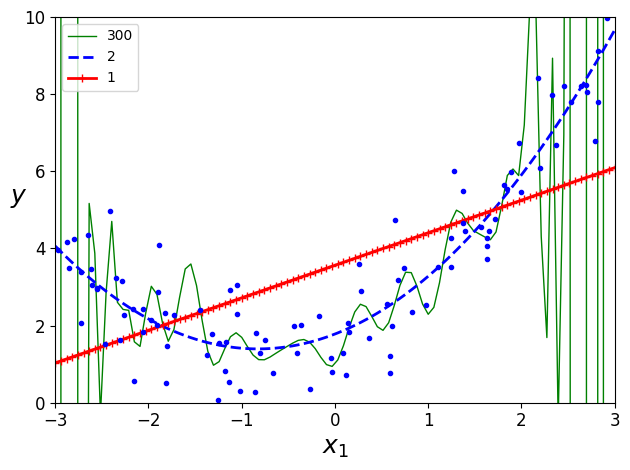

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# 세 개의 다항 회귀 모델 지정: 차례 대로 300차 다항 회귀, 2차 다항 회귀, 1차 선형 회귀 모델의 예측값 그래프 그리기
for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):

    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)  # 다항 특성 변환기
    std_scaler = StandardScaler()                                             # 표준화 축척 조정
    lin_reg = LinearRegression()                                              # 선형 회귀 모델

    polynomial_regression = Pipeline([                         # 파이프라인: 전처리 + 선형 회귀 모델
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])

    polynomial_regression.fit(X, y)                                            # 훈련
    y_newbig = polynomial_regression.predict(X_new)                            # 예측

    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)       # 그래프 그리기

plt.plot(X, y, "b.", linewidth=3)                                              # 원 데이터 산점도
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
save_fig("high_degree_polynomials_plot")
plt.show()

### 학습 곡선

훈련 세트와 검증 세트에 대한 모델 성능의 변화를 추적하는 곡선이 __학습 곡선__이다.
모델 성능의 변화는 훈련 세트의 크기를 1부터 시작해서 최대값까지 바꾸면서
훈련된 모델의 성능을 훈련 세트와 검증 세트 각각에 대해 측정하는 방식으로 확인한다.

아래 코드는 훈련 세트와 검증 세트에 대한 평균 제곱근 오차(RMSE)의 변화를 추적하는 그래프를 그린다.

* `plot_learning_curves()` 함수
    - `model`: 훈련에 사용되는 모델 지정
    - `X`: 8대 2 비율로 훈련 세트와 검증 세트로 분리되는 데이터 셋
    - `y`: 역시 8대 2 비율로 분리되는 레이블 셋.
    - 하는 일: 모델의 학습 곡선 그래프 그리기

In [41]:
from sklearn.metrics import mean_squared_error           # MSE 수동 계산
from sklearn.model_selection import train_test_split     # 무작위 샘플링

def plot_learning_curves(model, X, y):
    # 8:2 로 분류
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []                    # MSE 추적 장치

    for m in range(1, len(X_train)):                     # m 개의 훈련 샘플을 대상으로 훈련
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        # MSE 기록
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)

#### 과소 적합 모델의 학습 곡선 특징

2차 다항식으로 생성된 데이터셋에 대한 선형 회귀 모델의 학습 곡선은 다음과 같으며,
전형적인 과소 적합의 양태를 잘 보여준다.

* 훈련 데이터(빨강)에 대한 성능
    * 훈련 세트가 커지면서 RMSE(평균 제곱근 오차)가 커짐
    * 훈련 세트가 어느 정도 커지면 더 이상 RMSE가 변하지 않음

* 검증 데이터(파랑)에 대한 성능
    * 검증 세트에 대한 성능이 훈련 세트에 대한 성능과 거의 비슷해짐

그림 저장: underfitting_learning_curves_plot


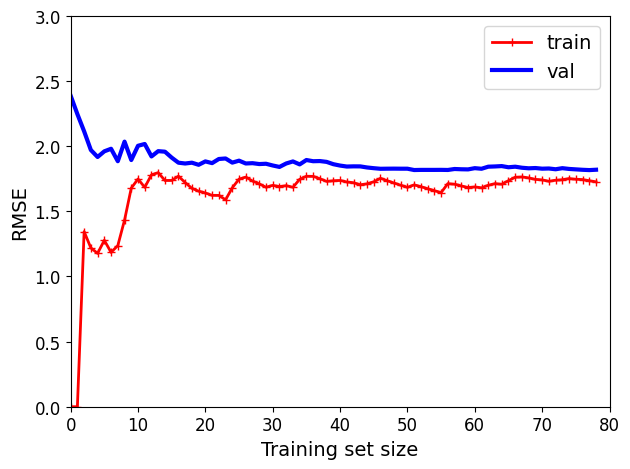

In [42]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])
save_fig("underfitting_learning_curves_plot")
plt.show()

#### 과대 적합 모델의 학습 곡선 특징

2차 다항식으로 생성된 데이터셋에 대해 10차 다항 회귀를 적용한 선형 회귀 모델의 학습 곡선은 다음과 같으며,
전형적인 과대 적합의 양태를 잘 보여준다.

* 훈련 데이터(빨강)에 대한 성능: 훈련 데이터에 대한 평균 제곱근 오차가 매우 낮음.
* 검증 데이터(파랑)에 대한 성능: 훈련 데이터에 대한 성능과 차이가 크게 벌어짐.
* 과대적합 모델 개선법: 훈련 데이터 추가

그림 저장: learning_curves_plot


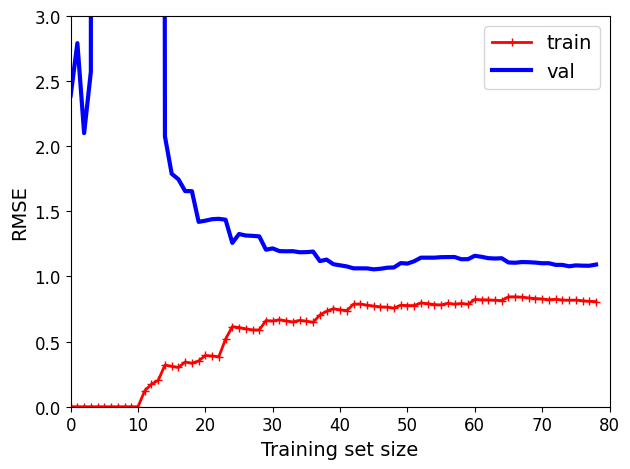

In [43]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])           # 책에는 없음
save_fig("learning_curves_plot")  # 책에는 없음
plt.show()                        # 책에는 없음

## 4.5 규제를 사용하는 선형 모델 (p. 184)

모델의 학습 과정에 규제를 가하는 방식으로 과대 적합을 감소시킬 수 있다.
다항 회귀 모델의 경우 다항식의 차수를 감소시키는 방식으로 규제할 수 있다.

선형 회귀 모델의 규제는 학습되는 일반적으로 파라미터에 제한을 두는 방식으로 이루어지며,
여기서는 다른 규제 방식이 적용된 세 모델을 소개한다.

* 릿지 회귀
* 라쏘 회귀
* 엘라스틱넷

또한 경사하강법과 같은 반복적인 학습 알고리즘의 검증 오류가 최솟값에 다달은 순간에 훈련을 중지시키는
__조기 종료__ 기법도 소개한다.

### 4.5.1 릿지 회귀 (p. 184)

아래 코드는 연습을 위해 1차 함수를 이용하여 20개의 훈련 데이터를 생성한다.

* `X`: 훈련 세트, 크기는 20.
* `X_new`: 100개의 검증용 데이터.

In [44]:
np.random.seed(42)

m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5     # 1차 선형회귀 모델을 따로도록 함. 단, 잡음 추가됨.
X_new = np.linspace(0, 3, 100).reshape(100, 1)    # 0~3 구간에서 균등하게 100개의 검증 데이터 선택

#### 릿지 회귀의 비용 함수

$$
\begin{align*}
J(\boldsymbol{\theta}) & = \text{MSE}(\boldsymbol{\theta}) + \dfrac{\alpha}{2}\sum\limits_{i=1}^{n}{\theta_i}^2 \\
& = \text{MSE}(\boldsymbol{\theta}) + \dfrac{\alpha}{2}\left (\theta_1^2 + \cdots + \theta_n^2 \right )
\end{align*}
$$

#### `Ridge` 모델

릿지 규제를 지원한다.

* `solver=cholesky`: 원래는 경사하강법을 계산하는 옵티마이저 지정.
    하지만 `cholesky`를 지정하면 정규방정식을 이용하여 최적의 파라미터를 계산함.
* `alpha=1`: 규제 강도를 나타냄. 값이 클 수록 규제가 세짐. 이유는 비용 함숫값을 줄이기 위해
    $\theta_i$ 값들이 작아지도록 강요되기 때문임.

In [45]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([1.55071465])

* `solver=sag`: 경사하강법을 지원하는 다양한 옵티마이저 중에 하나임. 계속해서 보다 개선된 옵티마이저가 개발됨.

In [46]:
ridge_reg = Ridge(alpha=1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([1.55072189])

아래 코드는 다양한 `alpha` 값의 영향력를 그래프로 보여준다.
오른편 그래프는 10차 다항 회귀가 적용된 경우 3 개를 보여준다.
`alpha`를 크게 할 수록 예측값의 그래프가 직선에 가까워짐을 볼 수 있다.

그림 저장: ridge_regression_plot


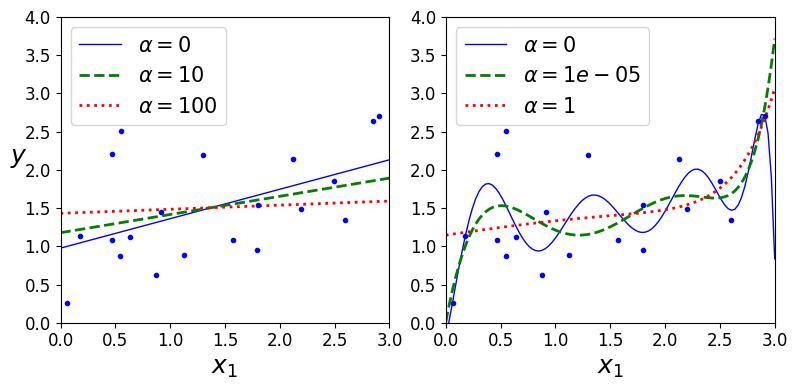

In [47]:
from sklearn.linear_model import Ridge

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),           # 표준화 축척 조정
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

save_fig("ridge_regression_plot")
plt.show()

#### SGDRegressor 와 릿지 회귀

SGDRegressor 모델의 `penalty` 하이퍼파라미터를 이용하면 릿지 회귀와 동일하게 작동한다.

* `penalty="l2"`. 기본값임.
* `l2`: 아래 $\ell_2$ 노름을 가리킴

$$\theta_1^2 + \cdots + \theta_n^2$$

**참고**: `max_iter=1000`과 `tol=1e-3`이 기본 값으로 사용된다.

In [48]:
sgd_reg = SGDRegressor(penalty="l2", alpha=1, max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.38390205])

### 4.5.2 라쏘 회귀 (p.187)

#### 라쏘 회귀의 비용 함수

$$
\begin{align*}
J(\boldsymbol{\theta}) & = \text{MSE}(\boldsymbol{\theta}) + \alpha \sum\limits_{i=1}^{n}\left| \theta_i \right| \\
& = \text{MSE}(\boldsymbol{\theta}) + \alpha \left (\, \left| \theta_1 \right| + \cdots + \left| \theta_n \right|\, \right )
\end{align*}
$$

#### `Lasso` 모델

라쏘 규제를 지원한다.

* `alpha=0.1`

__참고:__ 릿지 회귀에 사용된 `alpha` 값보다 작은 값을 사용하였다.
이유는 릿지 회귀는 파라미터를 제곱해서 사용하는 반면에 라쏘 회귀에서는 파라미터의 절댓값을 사용하기 때문에
`alpha`가 작더라도 규제에 큰 영향을 주기 때문이다.

In [49]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

아래 코드는 라쏘 규제에 사용되는 다양한 `alpha` 값의 영향을 비교해준다.
오른편 그래프는 10차 다항회귀에 적용된 라쏘 회귀 모델의 예측값을 보여준다.
10차 다항 회귀라 하더라도 규제를 세개 주면 마차 3차 다항회귀를 준 것처럼 작동하게 함을 잘 보여준다.

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.803e+00, tolerance: 9.295e-04
  model = cd_fast.enet_coordinate_descent(


그림 저장: lasso_regression_plot


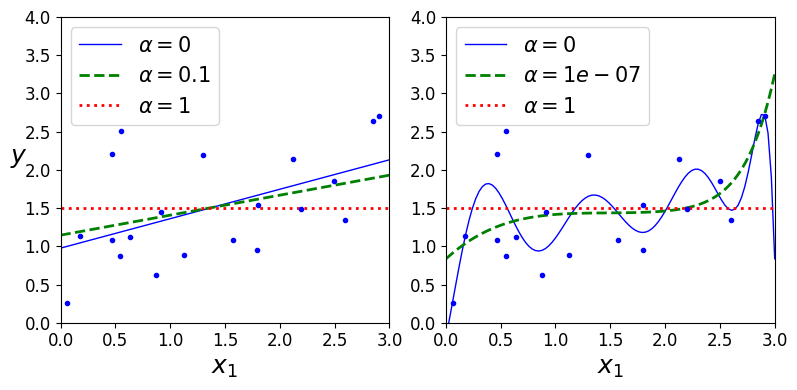

In [50]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), random_state=42)

save_fig("lasso_regression_plot")
plt.show()

#### SGDRegressor 와 라쏘 회귀

SGDRegressor 모델의 `penalty` 하이퍼파라미터를 이용하면 릿지 회귀와 동일하게 작동한다.

* `penalty="l1"`
* `l1`: 아래 $\ell_1$ 노름을 가리킴

$$\sum_{i=1}^n \left | \theta_i \right | = \left | \theta_1 \right | + \cdots + \left | \theta_n \right |$$

**참고**: `max_iter=1000`과 `tol=1e-3`이 기본 값으로 사용된다.

In [51]:
sgd_reg = SGDRegressor(penalty="l1", alpha=0.1, max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.45526648])

#### &#x270b; 라쏘 회귀와 릿지 회귀 비교 (그림 4-19, 책 189쪽)

아래 코드는 라쏘 회귀와 릿지 회귀 모델 학습 과정 동안 경사 하강법이 적용될 때
파라미터가 움직이는 특성을 비교해서 보여주기 위한 코드이다.

핵심은 다음과 같으며 보다 자세한 설명은 책 188~189쪽을 참조하기 바란다.

- 상단 왼편: $\ell_1$ 노름의 그레이디언트 벡터의 움직임.
    $\theta_2$처럼 파라미터 값이 작을 수록 먼저 0에 수렴하는 것이 보여짐.
    훈련 과정에서는 별로 중요하지 않은 속성을 빠르게 무시하는 효과를 보여줌.
- 상단 오른편: $\ell_1$ 노름이 추가된 평균 제곱 오차(MSE) 함수의 그레이디언트 벡터의 움직임.
    $\theta_2$가 먼저 줄어드는 것을 잘 보여줌.
    전역 최저점에 근처에서 진동함. 이유는 절댓값의 미분이 0에서 정의되어 있지 않기 때문임.
- 하단 왼편: $\ell_2$ 노름의 그레이디언트 벡터의 움직임.
    모든 파라미터가 원점에 직선으로 달려가는 형태로 줄어듬.
- 하단 오른편: $\ell_2$ 노름이 추가된 평균 제곱 오차(MSE) 함수의 그레이디언트 벡터의 움직임.
    파라미터가 전역 최저점 근처에서 느려짐. 이유는 그레이디언트가 작아지기 때문임.

In [52]:
# 도표에 사용되는 좌표값 모음
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1/len(Xr) * np.sum((T.dot(Xr.T) - yr.T)**2, axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(np.argmin(J), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

그림 저장: lasso_vs_ridge_plot


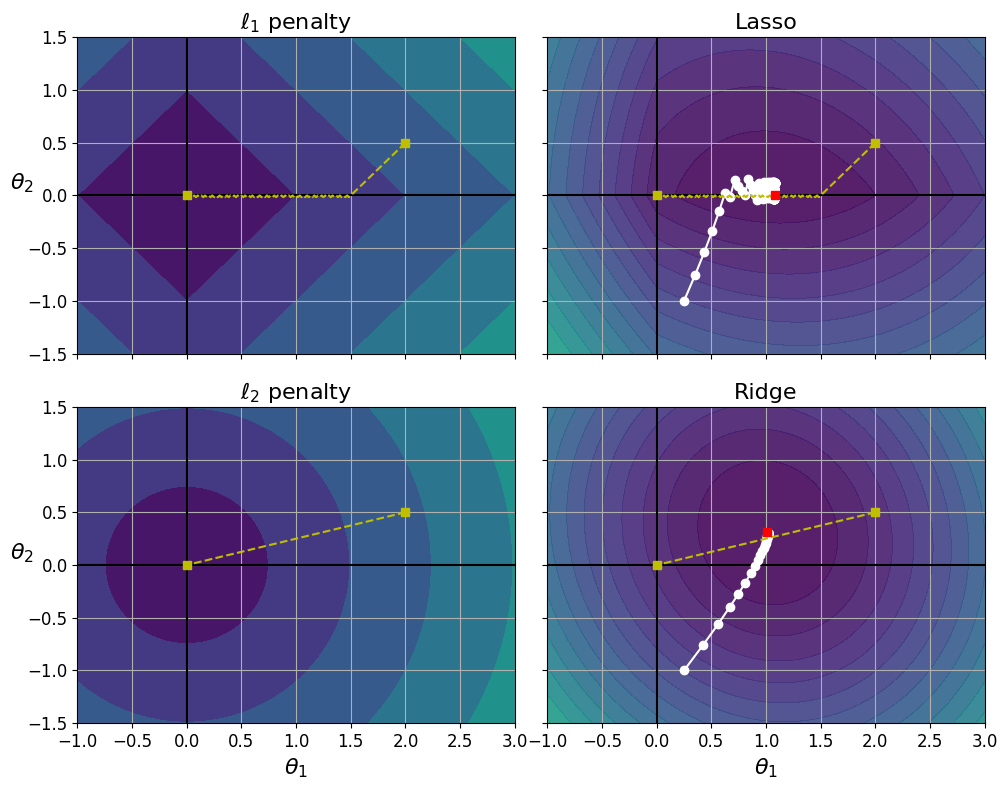

In [53]:
# 파라미터(theta) 경로 기억 어레이 생성 함수
def bgd_path(theta, X, y, l1, l2, core = 1, eta = 0.05, n_iterations = 200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = core * 2/len(X) * X.T.dot(X.dot(theta) - y) + l1 * np.sign(theta) + l2 * theta
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))
for i, N, l1, l2, title in ((0, N1, 2., 0, "Lasso"), (1, N2, 0,  2., "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2**2

    tr_min_idx = np.unravel_index(np.argmin(JR), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    # 좌측 도표 등고선 용도
    levelsN=np.linspace(0, np.max(N), 10)
    levelsJR=(np.exp(np.linspace(0, 1, 20)) - 1) * (np.max(JR) - np.min(JR)) + np.min(JR)

    # 라쏘 또는 릿지 회귀 경사하강법 파라미터 경로
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)

    # l1 노름 또는 l2 노름 경사하강법 경로
    path_N = bgd_path(np.array([[2.0], [0.5]]), Xr, yr, np.sign(l1)/3, np.sign(l2), core=0)

    # 좌측 도표(상단: 라쏘, 하단: 릿지)
    ax = axes[i, 0]
    ax.grid(True)
    ax.axhline(y=0, color='k')                                     # x 축
    ax.axvline(x=0, color='k')                                     # y 축
    ax.contourf(t1, t2, N / 2., levels=levelsN)                    # 등고선

    ax.plot(path_N[:, 0], path_N[:, 1], "y--")                     # 노랑 점선
    ax.plot(0, 0, "ys")                                            # 원점
    ax.plot(t1_min, t2_min, "ys")                                  # 좌표 (2, 1)
    ax.set_title(r"$\ell_{}$ penalty".format(i + 1), fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)
    ax.set_ylabel(r"$\theta_2$", fontsize=16, rotation=0)

    # 우측 도표(상단: 라쏘, 하단: 릿지)
    ax = axes[i, 1]
    ax.grid(True)
    ax.axhline(y=0, color='k')                                      # x 축
    ax.axvline(x=0, color='k')                                      # y 축
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)             # 등고선

    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")                    # 흰색 점실선
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")                      # 노랑 점선
    ax.plot(0, 0, "ys")                                             # 원점
    ax.plot(t1_min, t2_min, "ys")                                   # 좌표 (2, 1)
    ax.plot(t1r_min, t2r_min, "rs")                                 # 빨강 점
    ax.set_title(title, fontsize=16)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$", fontsize=16)

save_fig("lasso_vs_ridge_plot")
plt.show()

### 4.5.3 엘라스틱 넷 (p. 190)

릿지 회귀와 라쏘 회귀의 절충 모델을 지원한다.

#### 엘라스틱넷 비용 함수

$$
J(\boldsymbol{\theta}) = \text{MSE}(\boldsymbol{\theta}) + r \alpha \sum\limits_{i=1}^{n}\left| \theta_i \right| + \dfrac{1 - r}{2} \alpha \sum\limits_{i=1}^{n}{{\theta_i}^2}
$$

#### `ElasticNet` 모델

엘라스틱넷을 지원한다.

* `alpha=0.1`: 규제 강도
* `l1_ratio=0.5`: 혼합 비율 $r$을 가리킴.

In [54]:
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

#### SGDRegressor 와 엘라스틱넷

SGDRegressor 모델의 `penalty` 하이퍼파라미터를 이용하면 릿지 회귀와 동일하게 작동한다.

* `penalty="elasticnet"`
* `l1_ratio`: 혼합 비율

**참고**: `max_iter=1000`과 `tol=1e-3`이 기본 값으로 사용된다.

In [55]:
sgd_reg = SGDRegressor(penalty="elasticnet", alpha=0.1, l1_ratio=0.5, max_iter=1000, tol=1e-3, random_state=42)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.45913103])

### 4.5.4 조기 종료 (p. 191)

아래 코드는 조기 종료 설명을 위해 사용될 100개의 데이터를 5:5 비율로 훈련/검증 세트로 분할한다.

* `m=100`: 전체 데이터셋 크기
* `X`: -3에서 3사이에서 무작위로 100개 값 선택
* `y`: 2차 다항식을 따르면서 생성된 타깃 100개. 잡음이 추가됨.

In [56]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

# 5:5로 훈련/검증 세트로 분할
X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

조기 종료 예제:

In [62]:
from copy import deepcopy

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=None, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # 중지된 곳에서 다시 시작합니다
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

아래 코드는 에포크를 늘려 가면서 훈련 세트와 검증 세트의 성능(RMSE)을 측정해서 기록한다.
에포크는 최대 500번이다.
이후에 훈련/검증 세트의 기록을 각각 빨강 점선과 파랑 실선 그래프로 그린다.

* `sgd_reg`: SGD 선형회귀 모델 사용.
    - `penalty=None`: 규제 사용하지 않음.
    - `learning_rate=constant`: 학습률을 일정하게 유지. 즉, 학습 스케줄 사용하지 않음.
    - `warm_start=True`: 에포크마다 경사 하강법을 적용할 때 선형 회귀 모델을 초기화 하지 않고 이전 에포크에서
        학습한 내용을 이어받아서 학습한다는 의미임.

그림 저장: early_stopping_plot


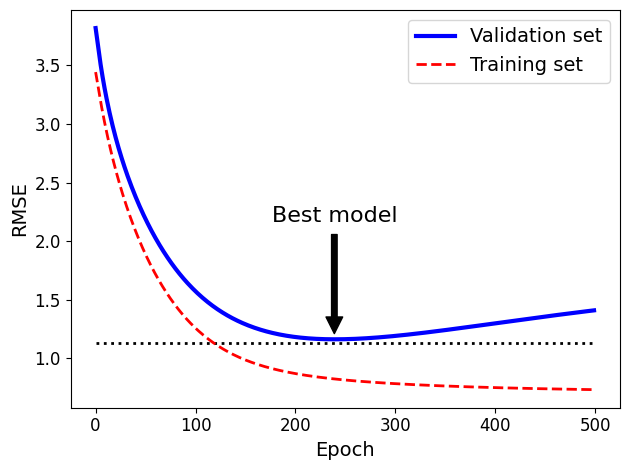

In [67]:
sgd_reg = SGDRegressor(max_iter=1, tol=None, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

n_epochs = 500

train_errors, val_errors = [], []                    # 훈련/검증 모델 성능 기록 장치

for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)        # warm_start=True 이기에 학습결과를 이어감.
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))  # 훈련/검증모델 성능 기록
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)                  # 최고 성능의 모델 기억해두기
best_val_rmse = np.sqrt(val_errors[best_epoch])

# 아래부터는 그래프 그리는 코드임.

plt.annotate('Best model',                          # 도표에 문장 넣는 기능. 내용과 위치를 정확히 지정함.
             xy=(best_epoch, best_val_rmse),        # 색상, 폰트 크기 등등을 일일이 지정함.
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # 검정 실선을 잘 보여주기 위해서임.
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)  # 수평 검정 점선
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")    # 파랑 실선
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")   # 빵강 파선

# 기타 추가 정보
plt.legend(loc="upper right", fontsize=14)  # 범례
plt.xlabel("Epoch", fontsize=14)            # 축 정보
plt.ylabel("RMSE", fontsize=14)
save_fig("early_stopping_plot")             # 저자가 사용하기 위해 그래프 저장하는 용도
plt.show()

가장 좋은 성능의 모델이 훈련된 에포크 수와 모델은 다음과 같음.

In [68]:
best_epoch, best_model

(np.int64(239),
 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
              random_state=42, tol=None, warm_start=True))

## 4.6 로지스틱 회귀 (p.193)

파라미터와 특성값들의 선형합에 시그모이드 함수를 적용하여 양성 확률을 추정하는 이진 분류 모델이다.

### 4.6.1 확률 추정 (p. 193)

확률 추정은 아래 식을 통해 이루어진다.

$$
\hat p = h_\theta(x) = \sigma(\theta^T\, \mathbf{x})
$$

$\sigma()$ 는 시그모이드 함수를 가리킨다.

$$
\sigma(t) = \frac{1}{1 + e^{-t}}
$$

샘플 $\mathbf{x}$에 대한 로지스틱 회귀 예측값은 다음과 같다.

$$
\hat y =
\begin{cases}
0 & \hat p < 0.5 \text{ 일때}\\
1 & \hat p \ge 0.5 \text{ 일때}
\end{cases}
$$

&#x270b; 아래 코드는 시그모이드 함수의 그래프를 그려준다.

그림 저장: logistic_function_plot


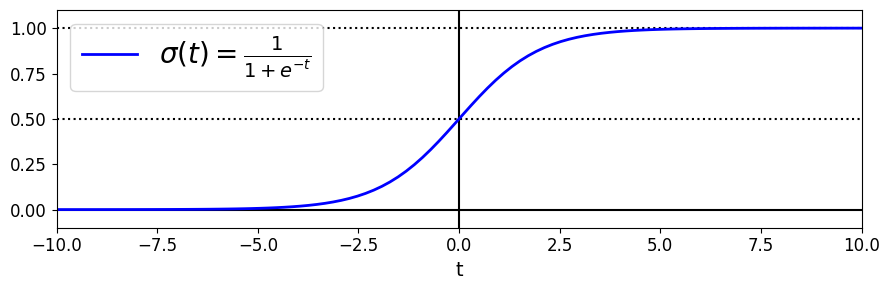

In [69]:
t = np.linspace(-10, 10, 100)
sig = 1 / (1 + np.exp(-t))
plt.figure(figsize=(9, 3))
plt.plot([-10, 10], [0, 0], "k-")
plt.plot([-10, 10], [0.5, 0.5], "k:")
plt.plot([-10, 10], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \frac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left", fontsize=20)
plt.axis([-10, 10, -0.1, 1.1])
save_fig("logistic_function_plot")
plt.show()

### 4.6.2 훈련과 비용 함수 (p. 195)

하나의 훈련 샘플에 대한 비용은 다음과 같다.

$$
c(\boldsymbol{\theta}) =
\begin{cases}
  -\log(\hat{p}) & \text{if } y = 1, \\
  -\log(1 - \hat{p}) & \text{if } y = 0.
\end{cases}
$$

예측을 잘못하면 비용이 매우 커진다.

<div align="center"><img src="https://raw.githubusercontent.com/codingalzi/handson-ml/master/slides/images/ch04/homl04-12-10a.png" width="600"/></div>

로지스틱 회귀 비용 함수(로그 손실)는 하나의 훈련 샘플에 대한 비용의 평균값이다.

$$
J(\boldsymbol{\theta}) = -\dfrac{1}{m} \sum\limits_{i=1}^{m}{\left[ y^{(i)} log\left(\hat{p}^{(i)}\right) + (1 - y^{(i)}) log\left(1 - \hat{p}^{(i)}\right)\right]}
$$

로지스틱 비용 함수의 편도 함수는 다음과 같다.
선형 회귀 비용 함수의 편도 함수와 매우 비슷하다. 단지 시그모이드 함수가 사용되었을 뿐이다.

$$
\dfrac{\partial}{\partial \theta_j} \text{J}(\boldsymbol{\theta}) = \dfrac{1}{m}\sum\limits_{i=1}^{m}\left(\mathbf{\sigma(\boldsymbol{\theta}}^T \mathbf{x}^{(i)}) - y^{(i)}\right)\, x_j^{(i)}
$$

__참고:__ 편도 함수가 선형 회귀의 경우와 매우 비슷한 것에 대한 확률론적 근거가 있다.
이에 대한 자세한 설명은 [앤드류 응(Andrew Ng) 교수의 Stanford CS229](https://www.youtube.com/watch?v=jGwO_UgTS7I&list=PLoROMvodv4rMiGQp3WXShtMGgzqpfVfbU)를 참조할 수 있다.

### 4.6.3 결정 경계 (p. 196)

붓꽃(iris) 데이터셋을 이용하여 로지스틱 회귀를 이용한 분류에 활용되는 결정 경계를 설명한다.
아래 코드는 사이킷런에서 제공하는 붓꽃 데이터셋을 번치(Bunch) 자료형으로 불러온다.

__참고:__ `Bunch` 자료형은 기본적으로 `dict` 자료형과 동일하다.
차이점은 인덱싱을 속성(attribute)처럼 처리할 수 있다는 것 뿐이다.

In [70]:
from sklearn import datasets
iris = datasets.load_iris()

데이터셋에 사용된 키는 다음과 같다.

In [71]:
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

`'data'` 키에 해당하는 값은 (150, 4) 모양의 넘파이 어레이다.

- 150: 150개의 붓꽃 샘플
- 4: 네 개의 특성. 차례대로 꽃받침 길이, 꽃받침 너비, 꽃잎 길이, 꽃잎 너비.

아래 코드는 처음 5개의 샘플 데이터를 보여준다.

__참고:__ 원래 `iris['data'][:5]`로 값을 확인하지만 `Bunch` 자료형이기에 아래와 같이 클래스의
속성 형식으로 확인할 수도 있다. 인용부호를 사용하지 않음에 주의해야 한다.

In [72]:
iris.data[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

`'target'` 키는 150개 붓꽃에 대한 품종을 1차원 어레이로 담고 있다.

- 0: 세토사(Iris-Setosa)
- 1: 버시컬러(Iris-Versicolor)
- 2: 버지니카(Iris-Virginica)

언급된 순서대로 50개씩 세 품종의 타깃이 저장되어 있으며,
처음 5개의 샘플은 세토사 품종임을 아래처럼 확인할 수 있다.

In [73]:
iris.target[:5]

array([0, 0, 0, 0, 0])

50번 인덱스부터는 버시컬러 품종이다.

In [74]:
iris.target[50:55]

array([1, 1, 1, 1, 1])

100번 인덱스부터는 버지니카 품종이다.

In [75]:
iris.target[100:105]

array([2, 2, 2, 2, 2])

이런 정보가 `'DESCR'` 속성에 저장되어 있다.

In [76]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

#### 이진 분류: 로지스틱 회귀

로지스틱 회귀는 기본적으로 이진 분류 모델이며, 일대다(OvR) 전략을 이용하여 다중 클래스 분류도 지원한다.
하지만 다중 클래스를 기본으로 지원하는 __소프트맥스 회귀__를 잠시 뒤에 소개한다.

__예제 1__

아래 코드는 이진 분류 설명을 위해 꽃잎 너비(petal width) 특성을 이용하여 버지니카 품종 여부를 판정하는 데에
사용되는 데이터셋을 지정한다.

In [78]:
X = iris["data"][:, 3:]                   # 1개의 특성(꽃잎 너비)만 사용
y = (iris["target"] == 2).astype(int)  # 버지니카(Virginica) 품종일 때 1(양성)

이제 사이킷런의 LogisticRegression 모델을 훈련시킨다.

**참고**: 사이킷런 0.22 버전의 기본값인 `solver="lbfgs"`로 지정

In [79]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X, y)

LogisticRegression(random_state=42)

1000개의 샘플을 새로 생성하여 훈련된 로지스틱 회귀 모델의 예측 결과를 도표로 확인하면 다음과 같다.

* `X_new`: 0~3구간을 1000등분한 값 1000개. 즉, 꽃잎의 너비를 0에서 3사이에서 1000개 선택.
* `y_proba`: 각 샘플에 대한 양성 확률
- x 축: 꽃잎 너비 크기
- 초록 실선: 버지니카(양성) 확률
- 파랑 점선: 버지니카가 아닌(음성) 확률

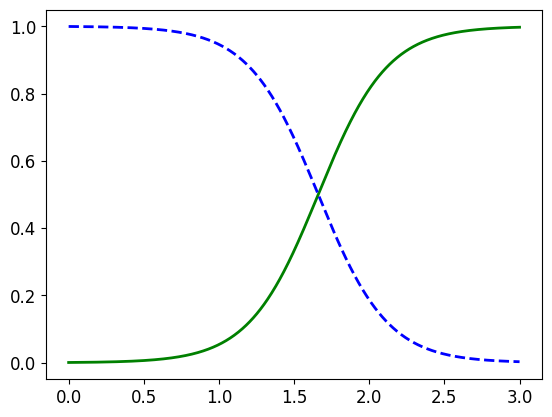

In [80]:
X_new = np.linspace(0, 3, 1000).reshape(1000, 1)
y_proba = log_reg.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")

&#x270b; 아래 코드는 보다 많은 정보를 도표와 함께 전달한다.

- y=1.0를 지난 수평선
- x=1.66 근처의 결정 경계(decision boundary): 검은 수직 점선
- 초록 삼각형: 버지니카 품종
- 파랑 사각형: 버지니카 아닌 품종

그림 저장: logistic_regression_plot


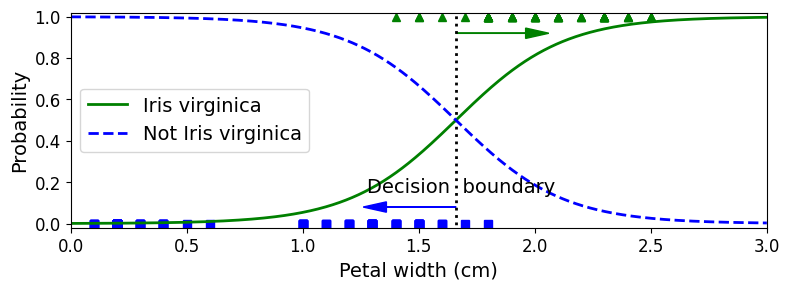

In [82]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary[0], decision_boundary[0]], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary[0]+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary[0], 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary[0], 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
save_fig("logistic_regression_plot")
plt.show()

양성 확률이 0.5가 되는 꽃잎 너비의 길이, 즉 결정 경계는 1.66이다.

In [83]:
decision_boundary

array([1.66066066])

실제로 1.66보다 크면 양성, 작으면 음성으로 판정한다.

In [84]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

__예제 2__

아래 코드는 이진 분류 설명을 위해 꽃잎 길이와 너비 두 개의 특성을 이용하여
버지니카 품종 여부를 판정하는 모델을 훈련한다.

In [88]:
X = iris["data"][:, (2, 3)]                  # 꽃잎 길이와 너비
y = (iris["target"] == 2).astype(int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

LogisticRegression(C=10000000000, random_state=42)

In [86]:
X = iris["data"][:, (2, 3)]                  # 꽃잎 길이와 너비
y = (iris["target"] == 2).astype(int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)

LogisticRegression(C=10000000000, random_state=42)

훈련 결과를 도표로 그리면 다음과 같다.

- 검은 실선: 결정 경계
- 다른 직선들: 버지니카(양성) 추정 확률별 결정 경계를 보여줌.

그림 저장: logistic_regression_contour_plot


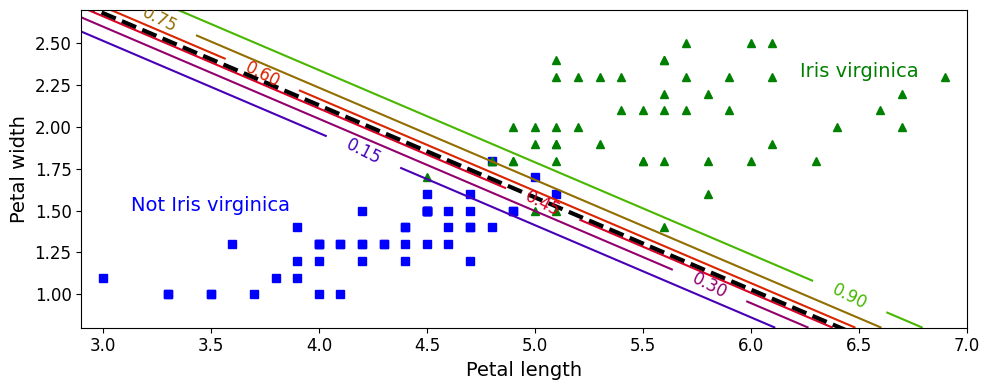

In [89]:
x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = log_reg.predict_proba(X_new)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs")
plt.plot(X[y==1, 0], X[y==1, 1], "g^")

zz = y_proba[:, 1].reshape(x0.shape)
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)


left_right = np.array([2.9, 7])
boundary = -(log_reg.coef_[0][0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0][1]

plt.clabel(contour, inline=1, fontsize=12)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.5, "Not Iris virginica", fontsize=14, color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", fontsize=14, color="g", ha="center")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])
save_fig("logistic_regression_contour_plot")
plt.show()

### 소프트맥스 회귀 (p. 199)

소프트맥스 회귀는 다중 클래스 분류를 지원한다.
샘플 $\mathbf{x}$가 주어지면 먼저 각 클래스별로 속할 점수 $s_k(\mathbf{x})$를 계산한 후에
아래 소프트맥스 함수를 이용하여 각 클래스에 속할 확률을 계산한다.

$$
\hat{p}_k = \sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}
$$

- $K$: 클래스 수
- $\mathbf{s}(\mathbf{x})$: 샘플 $\mathbf{x}$에 대한 각 클래스의 점수를 담은 벡터
- $\sigma\left(\mathbf{s}(\mathbf{x})\right)_k$: 샘플 $\mathbf{x}$가 클래스 $k$에 속할 추정 확률

#### 예측값

소프트맥스 회귀 분류기의 예측값은 추정 확률값이 가장 큰 클래스 $k$이다.

$$
\hat y =
\mathrm{argmax}_k s_k(\mathbf x)
$$

#### 비용함수와 그레이디언트 벡터

소프트맥스 회귀의 (크로스 엔트로피) 비용 함수는 다음과 같다.

$$
J(\boldsymbol{\Theta}) = - \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}
$$

클래스 $k$에 대한 (크로스 엔트로피) 비용함수의 그레이디언트 벡터는 다음과 같다.

$$
\nabla_{\boldsymbol{\theta}^{(k)}} \, J(\boldsymbol{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}
$$

#### 예제 3

꽃잎의 길이와 너비 특성을 이용하여 붓꽃 샘플을 세 개의 품종으로 분류한다.
`LogisticRegression` 모델을 이용하여 소프트맥스 회귀를 실행할 수 있다.

- `multi_class="multinomial"`: 소프트맥스 회귀 지정
- `solver="lbfgs"`: 경사하강법 알고리즘 지정
- `C=10`: 릿지 규제 강도. `alpha`의 역수에 해당. 따라서 작을 수록 강한 규제를 나타냄.

In [90]:
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(C=10, multi_class='multinomial', random_state=42)

훈련 결과를 도표로 그리면 다음과 같다.

- 노랑 원: 세토사
- 파랑 사각형: 버시컬러
- 초록 삼각형: 버지니카

- 결정 경계: 색상으로 구분됨
- 다른 직선들: 버시컬러 품종 추정 확률별 결정 경계를 보여줌.

그림 저장: softmax_regression_contour_plot


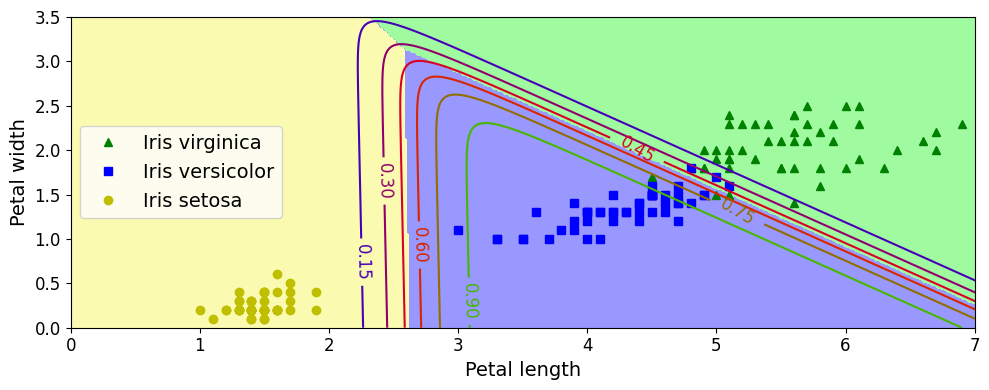

In [91]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]


y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
save_fig("softmax_regression_contour_plot")
plt.show()

꽃잎의 길이 5, 꽃잎의 너비 2인 붓꽃의 품종은 버지니카(2)이다.

In [92]:
softmax_reg.predict([[5, 2]])

array([2])

품종별 추정 확률은 다음과 같다.

* 세토사 추정 확률: 0%
* 버시컬러 추정 확률: 5.75%
* 버지니카 추정 확률: 94.25%

In [93]:
softmax_reg.predict_proba([[5, 2]])

array([[6.21626374e-07, 5.73689802e-02, 9.42630398e-01]])

## 연습문제 해답

1번부터 11번 문제에 대한 설명과 정답은 책의 부록 A를 참조하라.

### 문제 12

조기 종료를 사용한 배치 경사 하강법으로 소프트맥스 회귀를 구현하라.
단,  사이킷런을 전혀 사용하지 않아야 한다.
이런 경험을 통해 머신러닝 모델의 작동원리를 보다 깊이 이해할 수 있다.

__단계 1: 데이터 준비__

붓꽃 데이터셋의 꽃잎 길이(petal length)와 꽃잎 너비(petal width) 특성만 이용한다.

In [94]:
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 넓이
y = iris["target"]

모든 샘플에 편향을 추가한다. 이유는 아래 수식을 행렬 연산으로 보다 간단하게
처리하기 위해 0번 특성값 $x_0$이 항상 1이라고 가정하기 때문이다.

$$
\theta_0\cdot 1 + \theta_1\cdot x_1 + \cdots + \theta_n\cdot x_n =
\theta_0\cdot x_0 + \theta_1\cdot x_1 + \cdots + \theta_n\cdot x_n
$$

In [95]:
X_with_bias = np.c_[np.ones([len(X), 1]), X]

결과를 일정하게 유지하기 위해 랜덤 시드를 지정합니다:

In [96]:
np.random.seed(2042)

__단계 2: 데이터셋 분할__

데이터셋을 훈련, 검증, 테스트 용도로 6대 2대 2의 비율로 무작위로 분할한다.

- 훈련 세트: 60%
- 검증 세트: 20%
- 테스트 세트: 20%

아래 코드는 사이킷런의 `train_test_split()` 함수를 사용하지 않고
수동으로 무작위 분할하는 방법을 보여준다.
먼저 각 세트의 크기를 결정한다.

In [97]:
test_ratio = 0.2                                         # 테스트 세트 비율 = 20%
validation_ratio = 0.2                                   # 검증 세트 비율 = 20%
total_size = len(X_with_bias)                            # 전체 데이터셋 크기

test_size = int(total_size * test_ratio)                 # 테스트 세트 크기: 전체의 20%
validation_size = int(total_size * validation_ratio)     # 검증 세트 크기: 전체의 20%
train_size = total_size - test_size - validation_size    # 훈련 세트 크기: 전체의 60%

`np.random.permutation()` 함수를 이용하여 인덱스를 무작위로 섞는다.

In [98]:
rnd_indices = np.random.permutation(total_size)

인덱스가 무작위로 섞였기 때문에 무작위로 분할하는 효과를 얻는다.
방법은 섞인 인덱스를 이용하여 지정된 6:2:2의 비율로 훈련, 검증, 테스트 세트로 분할하는 것이다.

In [99]:
X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]

X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]

X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

__단계 3: 타깃 변환__

타깃은 0, 1, 2로 설정되어 있다. 차례대로 세토사, 버시컬러, 버지니카 품종을 가리킨다.
훈련 세트의 첫 5개 샘플의 품종은 다음과 같다.

In [100]:
y_train[:5]

array([0, 1, 2, 1, 1])

학습을 위해 타깃을 원-핫 벡터로 변환해야 한다.
이유는 소프트맥스 회귀는 샘플이 주어지면 각 클래스별로 속할 확률을 구하고
구해진 결과를 실제 확률과 함께 이용하여 비용함수를 계산하기 때문이다.

붓꽃 데이터의 경우 세 개의 품종 클래스별로 속할 확률을 계산해야 하기 때문에
품종을 0, 1, 2 등의 하나의 숫자로 두기 보다는 해당 클래스는 1, 나머지는 0인
확률값으로 이루어진 어레이로 다루어야 소프트맥스 회귀가 계산한 클래스별 확률과
연결된다.

아래 함수 `to_one_hot()` 함수는 길이가 m이면서 0, 1, 2로 이루어진 1차원 어레이가 입력되면
(m, 3) 모양의 원-핫 벡터를 반환한다.

In [101]:
def to_one_hot(y):
    n_classes = y.max() + 1                 # 클래스 수
    m = len(y)                              # 샘플 수
    Y_one_hot = np.zeros((m, n_classes))    # (샘플 수, 클래스 수) 0-벡터 생성
    Y_one_hot[np.arange(m), y] = 1          # 샘플 별로 해당 클래스의 값만 1로 변경. (넘파이 인덱싱 활용)
    return Y_one_hot

샘플 5개에 대해 잘 작동하는 것을 확인할 수 있다.

In [102]:
y_train[:5]

array([0, 1, 2, 1, 1])

In [104]:
to_one_hot(y_train[:5])

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

이제 훈련/검증/테스트 세트의 타깃을 모두 원-핫 벡터로 변환한다.

In [103]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot = to_one_hot(y_test)

__단계 4: 소프트맥스 함수 구현__

아래처럼 정의된 소프트맥스 함수를 파이썬 함수로 구현한다.

$$
\hat p_k = \sigma\left(\mathbf{s}(\mathbf{x})\right)_k
= \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}
$$

- $K$: 클래스 수
- $\theta^{(k)}$: 클래스 $k$에 해당하는 파라미터 벡터.
- $s_k(\mathbf{x})$: 샘플 $\mathbf{x}$의 클래스 $k$에 대한 점수

$$
s_k(\mathbf{x}) = (\theta^{(k)})^T\, \mathbf{x}
$$

$\theta^{(k)}$ 벡터의 길이는 특성 수와 동일하다.
예를 들어, 붓꽃 데이터셋의 경우 3 개의 품종 $k \in (0, 1, 2)$ 각각에 대해 길이가
3(세 개의 특성: 편향, 꽃잎 길이, 꽃잎 너비)인 벡터
$(\theta^{(k)}_0, \theta^{(k)}_1, \theta^{(k)}_2)$가 파라미터로 주어져야 한다.
따라서 총 9개의 파라미터가 (3, 3)-행렬 모양의 2차원 어레이로 훈련 과정에서 학습된다.

$$
\Theta =
\begin{bmatrix}
\theta_0^{(0)} & \theta_0^{(1)} & \theta_0^{(2)}\\
\theta_1^{(0)} & \theta_1^{(1)} & \theta_1^{(2)}\\
\theta_2^{(0)} & \theta_2^{(1)} & \theta_2^{(2)}
\end{bmatrix}
$$

아래에서 정의되는 `softmax()` 함수는
$s_k(\mathbf{x})  = (\theta^{(k)})^T\, \mathbf{x}$로 계산되는 각 샘플에 대한 클래스별 점수로
이루어진 (샘플 수, 클래스 수)-행렬 모양의 인자를 기대한다.

예를 들어, 붓꽃 훈련 세트의 크기가 90개이므로
아래 훈련 과정에서 사용되는 `softmax()` 함수의 인자는 다음과 같은 모양의
2차원 넘파이 어레이다.
단, $\mathbf{x}^{(i)}$는 $i$번째 샘플을 가리킨다.

$$
\mathbf{X}_{\textit{train}}\, \Theta =
\begin{bmatrix}
s_0(\mathbf{x}^{(1)}) & s_1(\mathbf{x}^{(1)}) & s_2(\mathbf{x}^{(1)})\\
s_0(\mathbf{x}^{(2)}) & s_1(\mathbf{x}^{(2)}) & s_2(\mathbf{x}^{(2)})\\
 & \vdots & \\
s_0(\mathbf{x}^{(90)}) & s_1(\mathbf{x}^{(90)}) & s_2(\mathbf{x}^{(90)})
\end{bmatrix}
$$

반면에 반환되는 값은 각 샘플에 대한 클래스별 확률로 구성된 아래 모양의 2차원 넘파이 어레이다.
$\hat p_k^{(n)}$은 $n$번째 샘플이 클래스 $k$에 속할 예측 확률을 가리킨다.

$$
\hat P =
\begin{bmatrix}
\hat p_0^{(1)} & \hat p_1^{(1)} & \hat p_2^{(1)}\\
\hat p_0^{(2)} & \hat p_1^{(2)} & \hat p_2^{(2)}\\
 & \vdots & \\
\hat p_0^{(90)} & \hat p_1^{(90)} & \hat p_2^{(90)}
\end{bmatrix}
$$

In [105]:
def softmax(logits):
    exps = np.exp(logits)                            # 항목별 지수함수 적용
    exp_sums = np.sum(exps, axis=1, keepdims=True)   # 샘플별 클래스 점수 합산
    return exps / exp_sums                           # 샘플별 소프트맥스 점수로 이루어진 어레이 반환

__단계 5: 경사하강법 활용 훈련__

경사하강법을 구현하기 위해 아래 비용함수와 비용함수의 그레이디언트를 파이썬으로
구현할 수 있어야 한다.

- 비용 함수($K$는 클래스 수, $m$은 샘플 수):

$$
J(\mathbf{\Theta}) =
- \dfrac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}{y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}
$$

- 그레이디언트 공식(클래스 $k$에 대해):

$$
\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}
$$

__주의사항:__
수학적으로 $\hat{p}_k^{(i)} = 0$이면
$\log\left(\hat{p}_k^{(i)}\right)$는 정의되지 않는다.
`NaN` 값을 피하기 위해
$\hat{p}_k^{(i)}$에 작은 값 `epsilon` 추가한다.
여기서는 `1e-7`을 사용한다.
사실 너무 작은 `epsilon`을 0에 더하면
컴퓨터가 그래도 0으로 취급할 수 있음에 조심해야 한다.

이제 훈련 코드를 작성할 수 있다.
클래스별 파라미터로 이루어진 $(n+1, K)$ 행렬 모양의 2차원 넘파이 어레이 $\Theta$를
생성하기 위해 $n$과 $K$를 확인한다.

In [106]:
n_inputs = X_train.shape[1]           # 특성 수(n) + 1, 붓꽃의 경우: 특성 2개 + 1
n_outputs = len(np.unique(y_train))   # 중복을 제거한 클래스 수(K), 붓꽃의 경우: 3개

파라미터 $\Theta$를 무작위로 초기 설정한다.

In [107]:
Theta = np.random.randn(n_inputs, n_outputs)

배치 경사하강법 훈련은 아래 코드를 통해 이루어진다.

- `eta = 0.01`: 학습률
- `n_iterations = 5001` : 에포크 수
- `m = len(X_train)`: 훈련 세트 크기, 즉 훈련 샘플 수
- `epsilon = 1e-7`: $\log$ 값이 항상 계산되도록 더해지는 작은 실수
- `logits`: 모든 샘플에 대한 클래스별 점수, 즉 $\mathbf{X}_{\textit{train}}\, \Theta$
- `Y_proba`: 모든 샘플에 대해 계산된 클래스 별 소속 확률, 즉 $\hat P$

In [108]:
#  배치 경사하강법 구현
eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

for iteration in range(n_iterations):     # 5001번 반복 훈련
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)

    if iteration % 500 == 0:              # 500 에포크마다 손실(비용) 계산해서 출력
        loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        print(iteration, loss)

    error = Y_proba - Y_train_one_hot     # 그레이디언트 계산.
    gradients = 1/m * X_train.T.dot(error)

    Theta = Theta - eta * gradients       # 파라미터 업데이트

0 5.446205811872683
500 0.8350062641405651
1000 0.6878801447192402
1500 0.6012379137693314
2000 0.5444496861981872
2500 0.5038530181431525
3000 0.4729228972192248
3500 0.44824244188957774
4000 0.4278651093928793
4500 0.41060071429187134
5000 0.3956780375390374


학습된 파라미터는 다음과 같다.

In [109]:
Theta

array([[ 3.32094157, -0.6501102 , -2.99979416],
       [-1.1718465 ,  0.11706172,  0.10507543],
       [-0.70224261, -0.09527802,  1.4786383 ]])

검증 세트에 대한 예측과 정확도는 다음과 같다.
`logits`, `Y_proba`를 검증 세트인 `X_valid`를 이용하여 계산한다.
예측 클래스는 `Y_proba`에서 가장 큰 값을 갖는 인덱스로 선택한다.

In [110]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)          # 가장 높은 확률을 갖는 클래스 선택

accuracy_score = np.mean(y_predict == y_valid)  # 정확도 계산
accuracy_score

np.float64(0.9666666666666667)

__단계 6: 규제가 추가된 경사하강법 활용 훈련__

$\ell_2$ 규제가 추가된 경사하강법 훈련을 구현한다.
코드는 기본적으로 동일하다.
다만 손실(비용)에 $\ell_2$ 페널티가 추가되었고
그래디언트에도 항이 추가되었다(`Theta`의 첫 번째 원소는 편향이므로 규제하지 않습니다).

- 학습률 `eta` 증가됨.
- `alpha = 0.1`: 규제 강도

In [111]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1        # 규제 하이퍼파라미터

Theta = np.random.randn(n_inputs, n_outputs)  # 파라미터 새로 초기화

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)

    if iteration % 500 == 0:
        xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        l2_loss = 1/2 * np.sum(np.square(Theta[1:]))  # 편향은 규제에서 제외
        loss = xentropy_loss + alpha * l2_loss        # l2 규제가 추가된 손실
        print(iteration, loss)

    error = Y_proba - Y_train_one_hot
    l2_loss_gradients = np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]   # l2 규제 그레이디언트
    gradients = 1/m * X_train.T.dot(error) + l2_loss_gradients

    Theta = Theta - eta * gradients

0 6.629842469083912
500 0.5339667976629505
1000 0.503640075014894
1500 0.4946891059460322
2000 0.4912968418075477
2500 0.48989924700933296
3000 0.4892990598451198
3500 0.48903512443978603
4000 0.4889173621830818
4500 0.4888643337449303
5000 0.4888403120738818


추가된 $\ell_2$ 페널티 때문에 이전보다 손실이 조금 커졌지만
검증 세트에 대한 정확도는 오히려 높아졌다.

In [112]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

np.float64(1.0)

정확도 1이면 완벽하다는 의미이지만 검증 세트에 대한 운이 좋았을 가능성이 매우 높다.

__단계 7: 조기 종료 추가__

위 규제가 사용된 모델의 훈련 과정에서
매 에포크마다 검증 세트에 대한 손실을 계산하여 오차가 줄어들다가 증가하기 시작할 때 멈추도록 한다.

In [115]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1            # 규제 하이퍼파라미터
best_loss = np.inf   # 최소 손실값 기억 변수

Theta = np.random.randn(n_inputs, n_outputs)  # 파라미터 새로 초기화

for iteration in range(n_iterations):
    # 훈련 및 손실 계산
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

    # 검증 세트에 대한 손실 계산
    logits = X_valid.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss

    # 500 에포크마다 검증 세트에 대한 손실 출력
    if iteration % 500 == 0:
        print(iteration, loss)

    # 에포크마다 최소 손실값 업데이트
    if loss < best_loss:
        best_loss = loss
    else:                                      # 에포크가 줄어들지 않으면 바로 훈련 종료
        print(iteration - 1, best_loss)        # 종료되지 이전 에포크의 손실값 출력
        print(iteration, loss, "조기 종료!")
        break

0 4.7096017363419875
500 0.5739711987633519
1000 0.5435638529109128
1500 0.5355752782580261
2000 0.5331959249285544
2500 0.5325946767399383
2765 0.5325460966791898
2766 0.5325460971327977 조기 종료!


훈련이 조기 종료 되었지만 검증 세트에 대한 정확도는 여전히 1이다.

In [116]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

np.float64(1.0)

&#x270b; __단계 8: 전체 데이터셋 대한 예측 결과 그래프__

전체 데이터셋에 대한 모델의 예측을 그래프로 그린다.

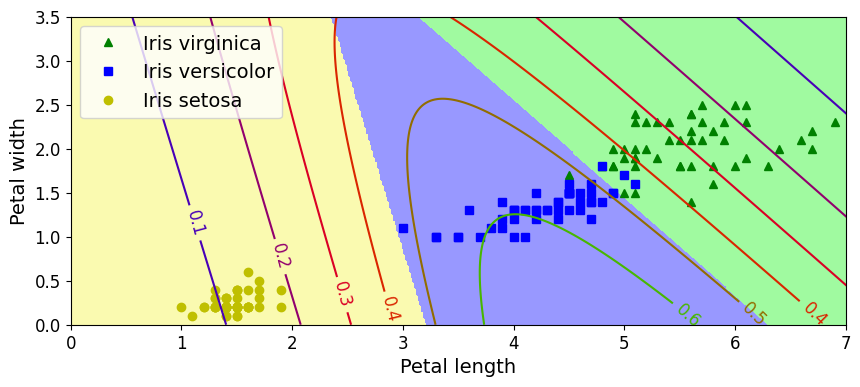

In [117]:
# (0, 8) x (0, 3.5) 크기의 직사각형 안의 모든 점을 대상으로 예측한 후에
# 예측 결과를 이용하여 색상으로 구분하고 등고선도 그리기 위한 준비작업
# 가로는 500개의 구간으로, 세로는 200개의 구간으로 쪼개짐.
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

# 직사각형 점 대상 예측하기
logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

# 등고선용 정보
zz1 = Y_proba[:, 1].reshape(x0.shape)                            # 버시컬러 기준 예측 확률
zz = y_predict.reshape(x0.shape)                                 # 예측값

# 붓꽃 샘플 그리기
plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")   # 녹색 삼각형, 버지니카
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")  # 파랑 사각형, 버시컬러
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")      # 노랑 원, 세토사

# 등고선 그리기
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)                       # 노랑, 청보라, 녹색 바탕색
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)              # 버시컬러 기준 예측 확률 등고선
plt.clabel(contour, inline=1, fontsize=12)

# 기타 도표 정보
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

__단계 9: 테스트 세트 평가__

마지막으로 테스트 세트에 대한 모델의 최종 성능을 정확도로 측정한다.

In [118]:
logits = X_test.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

np.float64(0.9333333333333333)

완벽했던 최종 모델의 성능이 조금 떨어졌다.
데이터셋이 작기 때문일 것으로 보인다.
또한 훈련/검증/테스트 세트의 분할 결과에도 영향을 받는다.
랜덤 시드를 바꾸고 이 코드를 다시 실행해 보면 결과가 달라질 것이다.

## 과제

### 과제 1

조기 종료를 사용한 배치 경사 하강법으로 로지스틱 회귀를 구현하라.
단, 사이킷런을 전혀 사용하지 않아야 한다.

### 과제 2

과제 1에서 구현된 로지스틱 회귀 알고리즘에 일대다(OvR) 방식을 적용하여 붓꽃에 대한 다중 클래스 분류 알고리즘을 구현하라. 단, 사이킷런을 전혀 사용하지 않아야 한다.

### 과제 3

A. 사진을 낮과 밤으로 분류하는 로지스틱 회귀 모델을 구현하라.

B. 사진을 낮과 밤, 실내와 실외로 분류하는 다중 레이블 분류 모델을 두 개의 로지스틱 회귀 모델을 이용하여 구현하라.

C. 과제 1에서 구현한 자신의 알고리즘과 사이킷런에서 제공하는 LogisticRegression 모델의 성능을 비교하라.

단, 모델 구현에 필요한 사진을 직접 구해야 한다. 최소 100장 이상의 사진 활용해야 한다.